# Libraries

In [1]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [2]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                                               'activity',
                                               'timestamp',
                                               'X',
                                               'Y',
                                               'Z'])
    ## removing ';' from last column and converting it to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
#     df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

In [3]:
df = read_data('Dataset/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


# Data Visualization

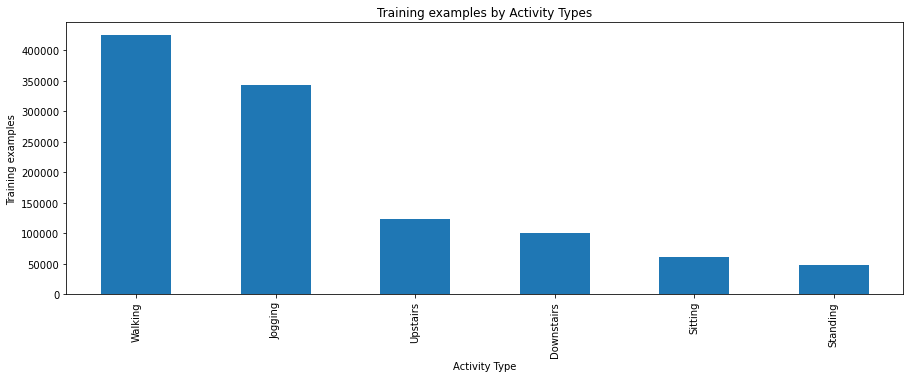

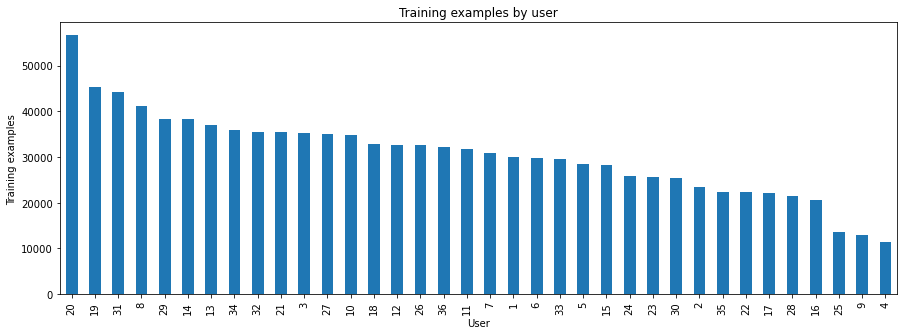

In [4]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [5]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

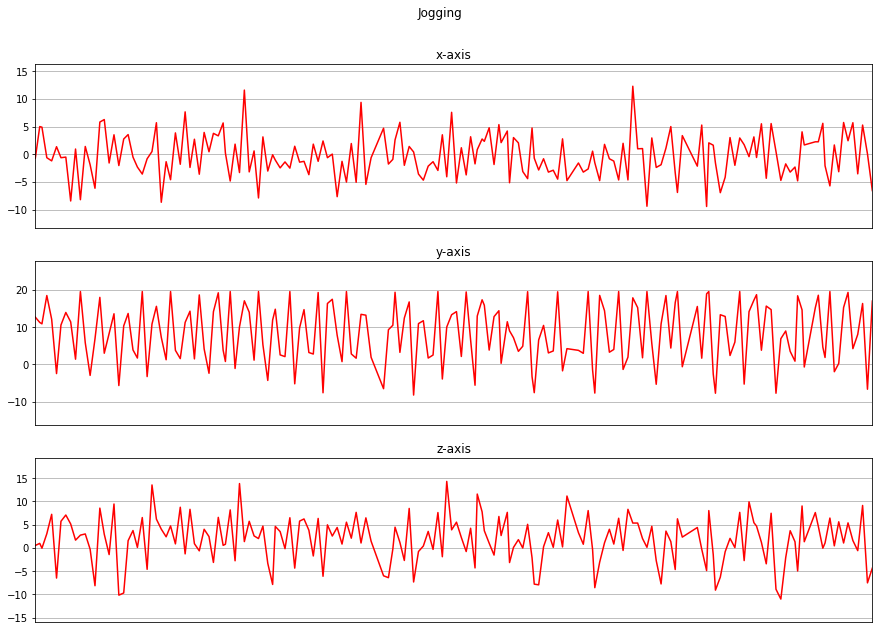

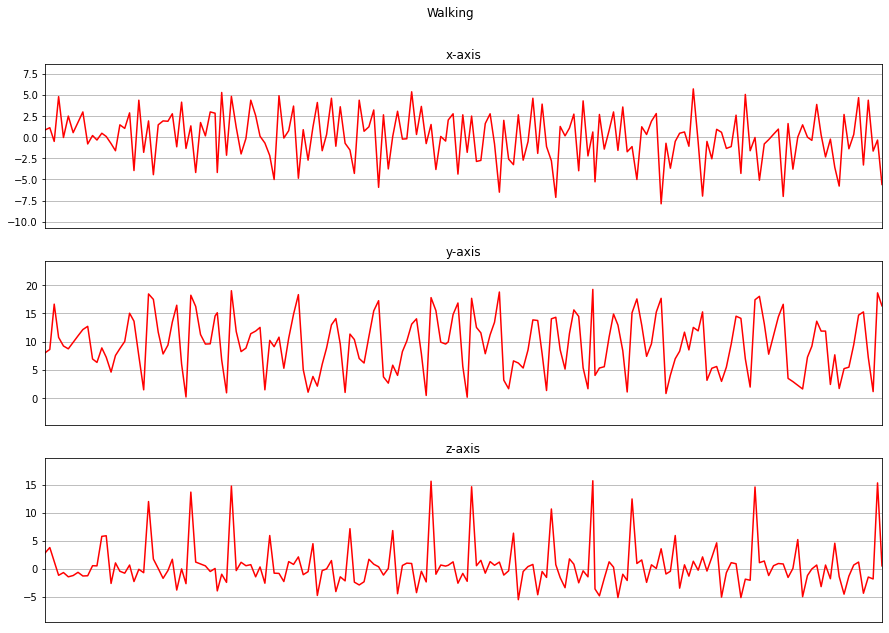

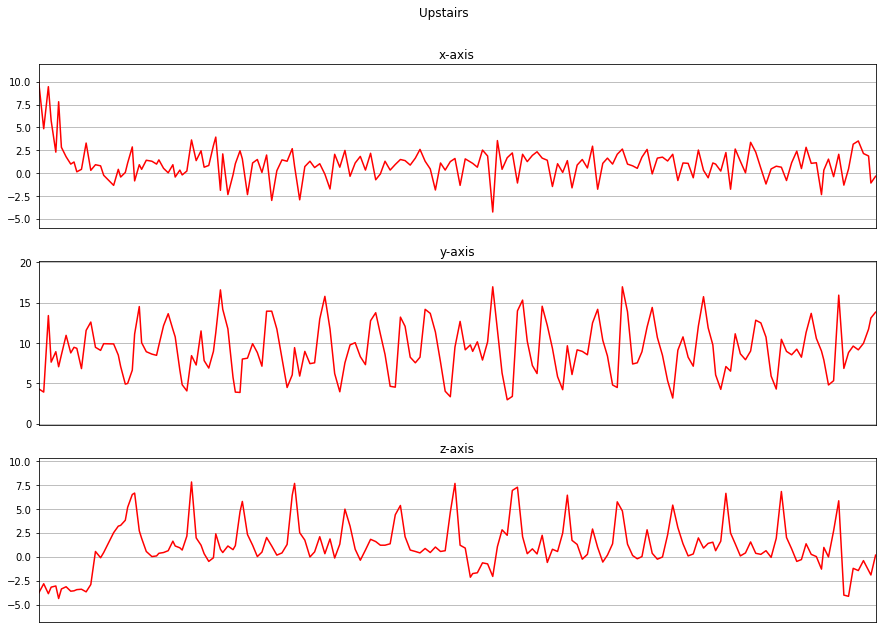

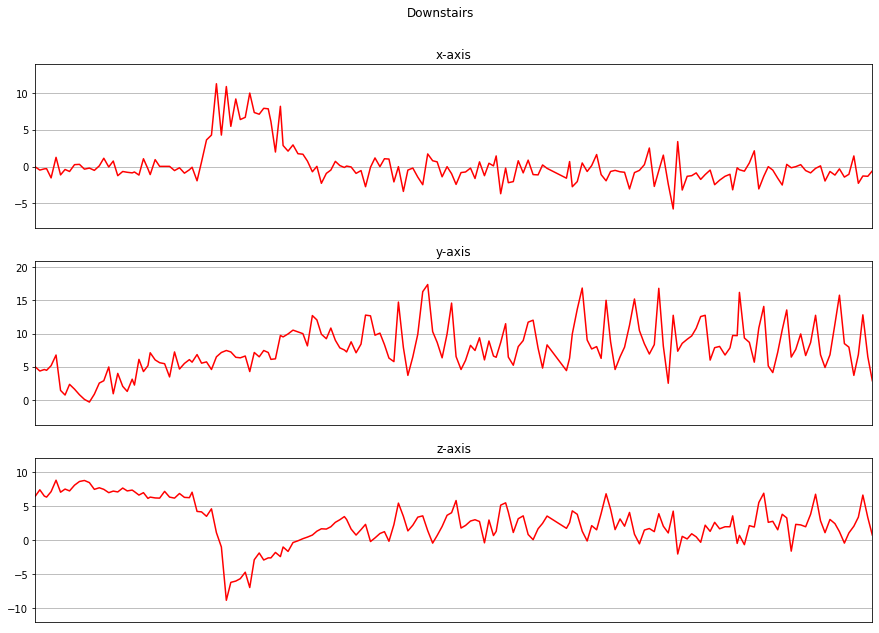

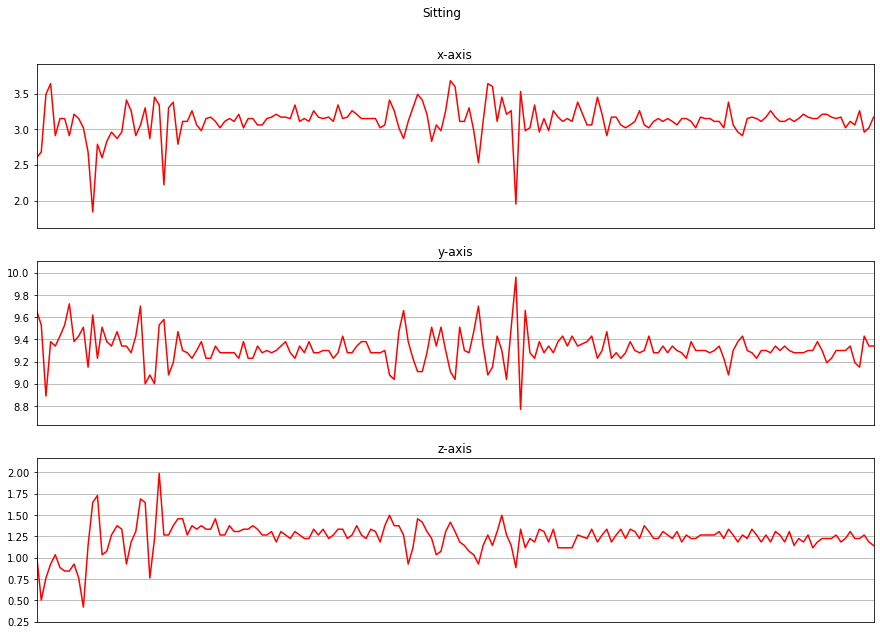

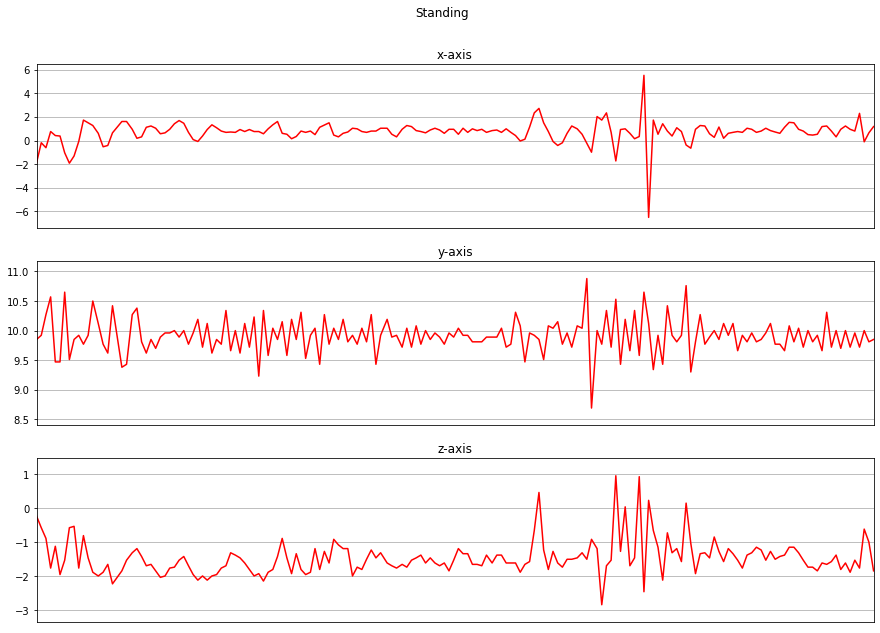

In [6]:
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Data Preprocessing

## Label Encoding

In [7]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


## Linear Interpolation

In [8]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 1
activityEncode    0
dtype: int64

In [9]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
interpolation_fn

In [10]:
null_list = df[df['Z'].isnull()].index.tolist()
null_list

[343416]

In [11]:
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

2.7921712000000003


In [12]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 0
activityEncode    0
dtype: int64

## Data split

In [13]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

## Normalization

In [14]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [15]:
df_train['activityEncode'].value_counts()

5    314341
1    262651
4     90906
0     71436
2     41932
3     32157
Name: activityEncode, dtype: int64

## Segmentation

In [16]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [17]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [19]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [20]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [30]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = np.expand_dims(x_train, 2)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240, 1)


In [31]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

## One-Hot Encoding

In [32]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


# Model

In [33]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 240, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 240, 32)           4352      
                                                                 
 lstm_6 (LSTM)               (None, 240, 32)           8320      
                                                                 
 reshape_6 (Reshape)         (None, 1, 240, 32)        0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 120, 64)        4160      
                                                                 
 reshape_7 (Reshape)         (None, 120, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                      

## Training

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history = model.fit(x_train,
                    y_train_hot, 
                    batch_size= 192, 
                    epochs=100
                   )

Epoch 1/100
106/106 [==============================] - 103s 900ms/step - loss: 0.8762 - accuracy: 0.7032
Epoch 2/100
106/106 [==============================] - 98s 921ms/step - loss: 0.5461 - accuracy: 0.8015
Epoch 3/100
106/106 [==============================] - 94s 882ms/step - loss: 0.4628 - accuracy: 0.8303
Epoch 4/100
106/106 [==============================] - 100s 942ms/step - loss: 0.4001 - accuracy: 0.8503
Epoch 5/100
106/106 [==============================] - 99s 928ms/step - loss: 0.3773 - accuracy: 0.8613
Epoch 6/100
106/106 [==============================] - 95s 899ms/step - loss: 0.3536 - accuracy: 0.8699
Epoch 7/100
106/106 [==============================] - 95s 899ms/step - loss: 0.3433 - accuracy: 0.8719
Epoch 8/100
106/106 [==============================] - 99s 939ms/step - loss: 0.3158 - accuracy: 0.8833
Epoch 9/100
106/106 [==============================] - 99s 934ms/step - loss: 0.3071 - accuracy: 0.8848
Epoch 10/100
106/106 [==============================] - 98s 92

106/106 [==============================] - 99s 937ms/step - loss: 0.0930 - accuracy: 0.9684
Epoch 80/100
106/106 [==============================] - 98s 920ms/step - loss: 0.0933 - accuracy: 0.9678
Epoch 81/100
106/106 [==============================] - 100s 941ms/step - loss: 0.0903 - accuracy: 0.9689
Epoch 82/100
106/106 [==============================] - 94s 890ms/step - loss: 0.0898 - accuracy: 0.9698
Epoch 83/100
106/106 [==============================] - 100s 948ms/step - loss: 0.0898 - accuracy: 0.9692
Epoch 84/100
106/106 [==============================] - 98s 927ms/step - loss: 0.0898 - accuracy: 0.9690
Epoch 85/100
106/106 [==============================] - 99s 930ms/step - loss: 0.0908 - accuracy: 0.9703
Epoch 86/100
106/106 [==============================] - 98s 924ms/step - loss: 0.0888 - accuracy: 0.9700
Epoch 87/100
106/106 [==============================] - 97s 913ms/step - loss: 0.0892 - accuracy: 0.9694
Epoch 88/100
106/106 [==============================] - 97s 920ms/

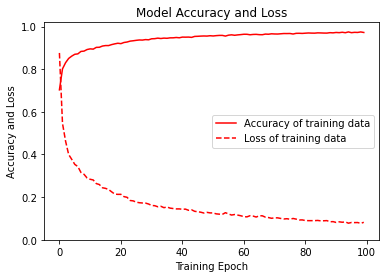

636/636 [==============================] - 55s 86ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.27      0.42      1788
         1.0       1.00      0.93      0.96      6570
         2.0       0.98      0.98      0.98      1049
         3.0       0.99      0.96      0.97       801
         4.0       0.77      0.67      0.72      2268
         5.0       0.79      1.00      0.88      7858

    accuracy                           0.87     20334
   macro avg       0.91      0.80      0.82     20334
weighted avg       0.89      0.87      0.86     20334



In [37]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

## Test

### Normalize test data

In [40]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
df_test

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,0.478144,0.820181,0.528758,1
1,33,Jogging,49106062271000,0.622404,0.784202,0.540574,1
2,33,Jogging,49106112167000,0.619649,0.774515,0.513362,1
3,33,Jogging,49106222305000,0.480209,0.967905,0.594998,1
4,33,Jogging,49106332290000,0.465749,0.805651,0.704920,1
...,...,...,...,...,...,...,...
832892,31,Standing,25207361641000,0.702983,0.612903,0.519453,3
832893,31,Standing,25207401497000,0.722194,0.600203,0.553891,3
832894,31,Standing,25207441536000,0.697169,0.618745,0.531546,3
832895,31,Standing,25207521553000,0.698180,0.619761,0.533649,3


### Segmentation & Reshaping

In [41]:
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

### Evaluate

In [42]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

223/223 [==============================] - 19s 84ms/step - loss: 1.2853 - accuracy: 0.7520
Accuracy: 0.7520371079444885
Loss: 1.2853337526321411


223/223 [==============================] - 19s 84ms/step


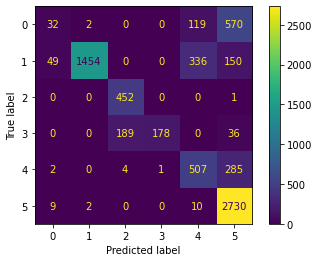

In [44]:
x_test = np.expand_dims(x_test, 2)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [45]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.35      0.04      0.08       723
           1       1.00      0.73      0.84      1989
           2       0.70      1.00      0.82       453
           3       0.99      0.44      0.61       403
           4       0.52      0.63      0.57       799
           5       0.72      0.99      0.84      2751

    accuracy                           0.75      7118
   macro avg       0.71      0.64      0.63      7118
weighted avg       0.75      0.75      0.72      7118

